# OCR(Optical Character Recognition, 광학 문자 인식)

기계가 문자를 읽는 과정은 1) Detection : 문자의 존재를 인식 2) Recognition : 어떤 문자인지 판독

이미지 내의 문자 인식 모델의 기본적인 방법 중 하나는 CNN과 RNN을 결합한 CRNN 모델이다. 이미니 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식한다.

## keras-ocr 써보기

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [2]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

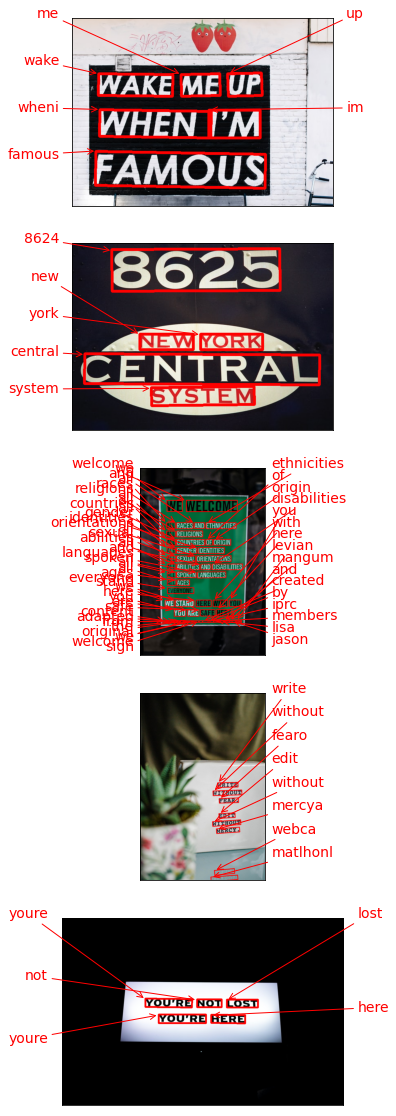

In [3]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 테서랙트 써보기

### 1) 테서랙트 설치
### 2) 테서랙트 파이썬 wrapper 설치

### 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [4]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_img.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png


### 4) 테서랙트로 잘린 이미지에서 단어 인식하기

In [5]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Ntro.

)

[


‘Mind

/des

reperes

Nutritionnel

FOO cp

desten:


bis:

COnsomm,

r pré

rOrii

Done


## 실습

3가지 COR모델을 검증해본다. 

In [6]:
# 라이브러리 버전 확인
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


## 1) 검증용 데이터셋 준비

In [7]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/text_images'
img_file_path = [work_dir + f'/{i}.jpg' for i in range(8)]

## 2) keras-ocr, Tesseract로 테스트 진행 (구글 OCR API는 선택 사항)

### 2-1) keras-ocr 

In [8]:
import matplotlib.pyplot as plt
import os
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [9]:
images = [keras_ocr.tools.read(path) for path in img_file_path]
prediction_groups = [pipeline.recognize([img]) for img in images]

### 2-2) 테서랙트

In [10]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

## 3) 테스트 결과 정리

Tesseract : Image 0
 

 

keras_ocr : Image 0


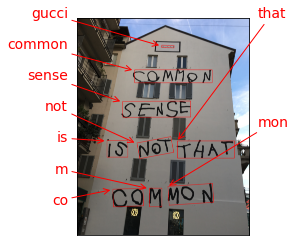

In [11]:
temp = 0

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

- 이미지 0

케라스 ocr은 detect와 recognize 모두 잘 된다. 다만 가장 밑의 'COMMON'은 문자 사이 간격을 공백으로 인식해 한 단어로 인식하지 못했다.

Tesseract : Image 1
 

keras_ocr : Image 1


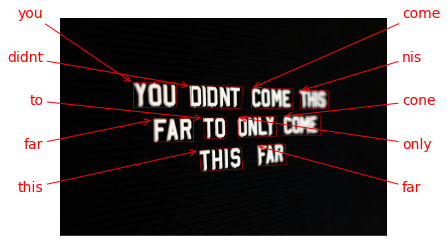

In [12]:
temp = 1

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

- 이미지 2 

텍스트의 각도가 휘어있다. 그렇지만 케라스는 인식이 잘 된다. 초점이 흐려서 뭉개지는 텍스트는 인식률이 떨어진다.

Tesseract : Image 2
  
 

on

dae

ie cosclie IF roe

 

 

 

al

 

 

keras_ocr : Image 2


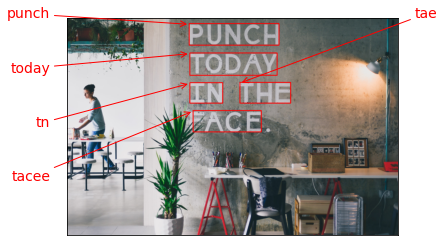

In [13]:
temp = 2

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

- 이미지 2

처음으로 테서랙트가 텍스트를 잡아내긴 했지만 어디서 저런 텍스트가 나왔는지 모를만큼 인식이 잘 되지 않았다. 

Tesseract : Image 3
THIS HOUSE
CLEAN
YESTERDAY

 

keras_ocr : Image 3


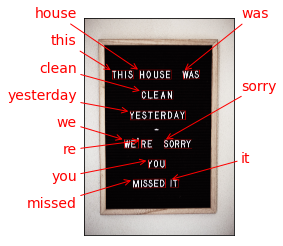

In [14]:
temp = 3

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

- 이미지 3

테서랙트가 완벽하게 텍스트를 잡아냈다. 하지만 반은 완전히 날라갔다. 이렇게 보면 작동은 하는 것 같은데 뭐가 문제인지는 잘 모르겠다.

Tesseract : Image 4
 

keras_ocr : Image 4


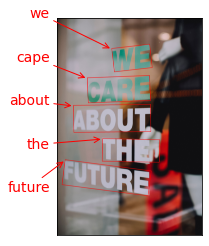

In [15]:
temp = 4

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

Tesseract : Image 5
 

 

 

 

 

 

 

 

keras_ocr : Image 5


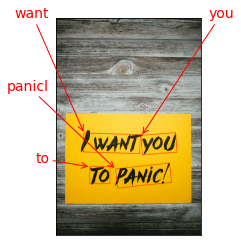

In [16]:
temp = 5

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

Tesseract : Image 6
 

keras_ocr : Image 6


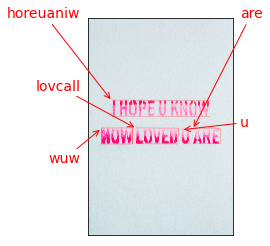

In [17]:
temp = 6

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

Tesseract : Image 7
 

keras_ocr : Image 7


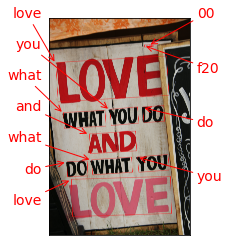

In [18]:
temp = 7

print(f'Tesseract : Image {temp}')
print(pytesseract.image_to_string(Image.open(img_file_path[temp])))

print(f'keras_ocr : Image {temp}')
keras_ocr.tools.drawAnnotations(image=images[temp],
                                    predictions=prediction_groups[temp][0])
plt.show()

## 4) 결과 분석과 결론 제시

테서렉트의 결과가 너무 좋지 못해서 비교가 힘들다. 